# 14.1b: Gradient Dynamics Analysis

**How do dead token updates change over time?**

## The Question

14.1a confirmed dead tokens receive non-zero gradients from the loss. Now we ask:
- How do gradient magnitudes evolve during training?
- Do step sizes (L∞ parameter updates) decay over time?
- Do all dead tokens behave similarly?

## Hypothesis

Early training:
- All tokens stacked → model predicts uniformly → large gradients for dead tokens

As training progresses:
- Live tokens scatter via gradients
- Model learns to predict dead tokens less often
- Dead token gradients decay
- Updates fall off within ~100 steps

## Parameters

In [17]:
# Data
DATA_PATH = "../data/instrumented_run/gradient_delta_history.safetensors"

# Visualization
DPI = 100
COLORMAP = 'inferno'
DEAD_TOKEN_ALPHA = 0.15  # Transparency for individual dead token lines

# Token of interest (for single-token plot)
EXAMPLE_TOKEN_CHAR = '&'  # ASCII 38
EXAMPLE_TOKEN_ID = ord(EXAMPLE_TOKEN_CHAR)

RANDOM_SEED = 42

## Imports

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [19]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

recorded_steps = data['recorded_steps'].numpy()
dead_token_ids = data['dead_token_ids'].tolist()
live_token_ids = data['live_token_ids'].tolist()

dead_grads = data['dead_grads']  # [n_recorded, n_dead, hidden_dim]
dead_deltas = data['dead_deltas']  # [n_recorded, n_dead, hidden_dim]

live_grads = data['live_grads']  # [n_recorded, n_live, hidden_dim]
live_deltas = data['live_deltas']  # [n_recorded, n_live, hidden_dim]

learning_rate = data['learning_rate'].item()
weight_decay = data['weight_decay'].item()

print(f"\n  Recorded steps: {recorded_steps}")
print(f"  Dead tokens: {len(dead_token_ids)}")
print(f"  Live tokens (sample): {len(live_token_ids)}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"\n✓ Data loaded")

Loading: ../data/instrumented_run/gradient_delta_history.safetensors

  Recorded steps: [    0    10    20 ...  9980  9990 10000]
  Dead tokens: 51
  Live tokens (sample): 10
  Learning rate: 0.0010000000474974513
  Weight decay: 0.009999999776482582

✓ Data loaded


## Compute Step Sizes (L∞ Distance)

In [20]:
# For each token at each step, compute L∞ norm of the update (max absolute component change)
dead_step_sizes = torch.abs(dead_deltas).max(dim=2)[0]  # [n_recorded, n_dead]
live_step_sizes = torch.abs(live_deltas).max(dim=2)[0]  # [n_recorded, n_live]

print(f"Dead token step sizes: {dead_step_sizes.shape}")
print(f"Live token step sizes: {live_step_sizes.shape}")

# Also compute gradient L∞ norms
dead_grad_norms = torch.abs(dead_grads).max(dim=2)[0]  # [n_recorded, n_dead]
live_grad_norms = torch.abs(live_grads).max(dim=2)[0]  # [n_recorded, n_live]

print(f"\n✓ Step sizes computed")

Dead token step sizes: torch.Size([1001, 51])
Live token step sizes: torch.Size([1001, 10])

✓ Step sizes computed


## Plot 1: Single Token ('&') Step Size Over Time

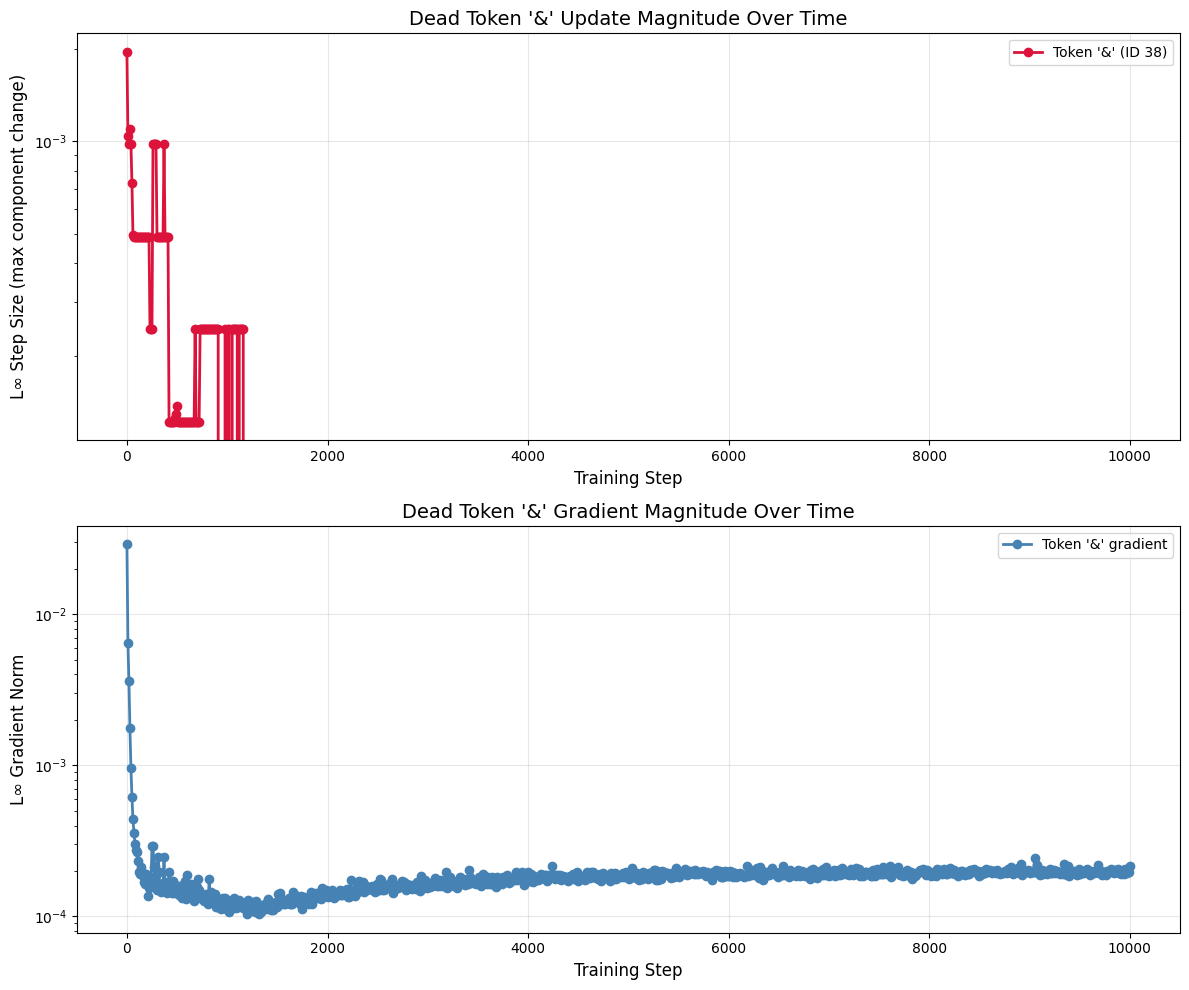


✓ Single token plot complete


In [29]:
# Find '&' in the dead token list
if EXAMPLE_TOKEN_ID in dead_token_ids:
    example_idx = dead_token_ids.index(EXAMPLE_TOKEN_ID)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=DPI)
    
    # Panel 1: Step size (L∞ update magnitude)
    axes[0].plot(recorded_steps, dead_step_sizes[:, example_idx].numpy(), 
                 marker='o', linewidth=2, color='crimson', label=f"Token '{EXAMPLE_TOKEN_CHAR}' (ID {EXAMPLE_TOKEN_ID})")
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('L∞ Step Size (max component change)', fontsize=12)
    axes[0].set_title(f"Dead Token '{EXAMPLE_TOKEN_CHAR}' Update Magnitude Over Time", fontsize=14)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(alpha=0.3)
    axes[0].set_yscale('log')
    
    # Panel 2: Gradient L∞ norm
    axes[1].plot(recorded_steps, dead_grad_norms[:, example_idx].numpy(), 
                 marker='o', linewidth=2, markersize=6, color='steelblue', label=f"Token '{EXAMPLE_TOKEN_CHAR}' gradient")
    axes[1].set_xlabel('Training Step', fontsize=12)
    axes[1].set_ylabel('L∞ Gradient Norm', fontsize=12)
    axes[1].set_title(f"Dead Token '{EXAMPLE_TOKEN_CHAR}' Gradient Magnitude Over Time", fontsize=14)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Single token plot complete")
else:
    print(f"\nToken '{EXAMPLE_TOKEN_CHAR}' (ID {EXAMPLE_TOKEN_ID}) is not a dead token!")

## Plot 2: All Dead Tokens Step Sizes (Overlay)

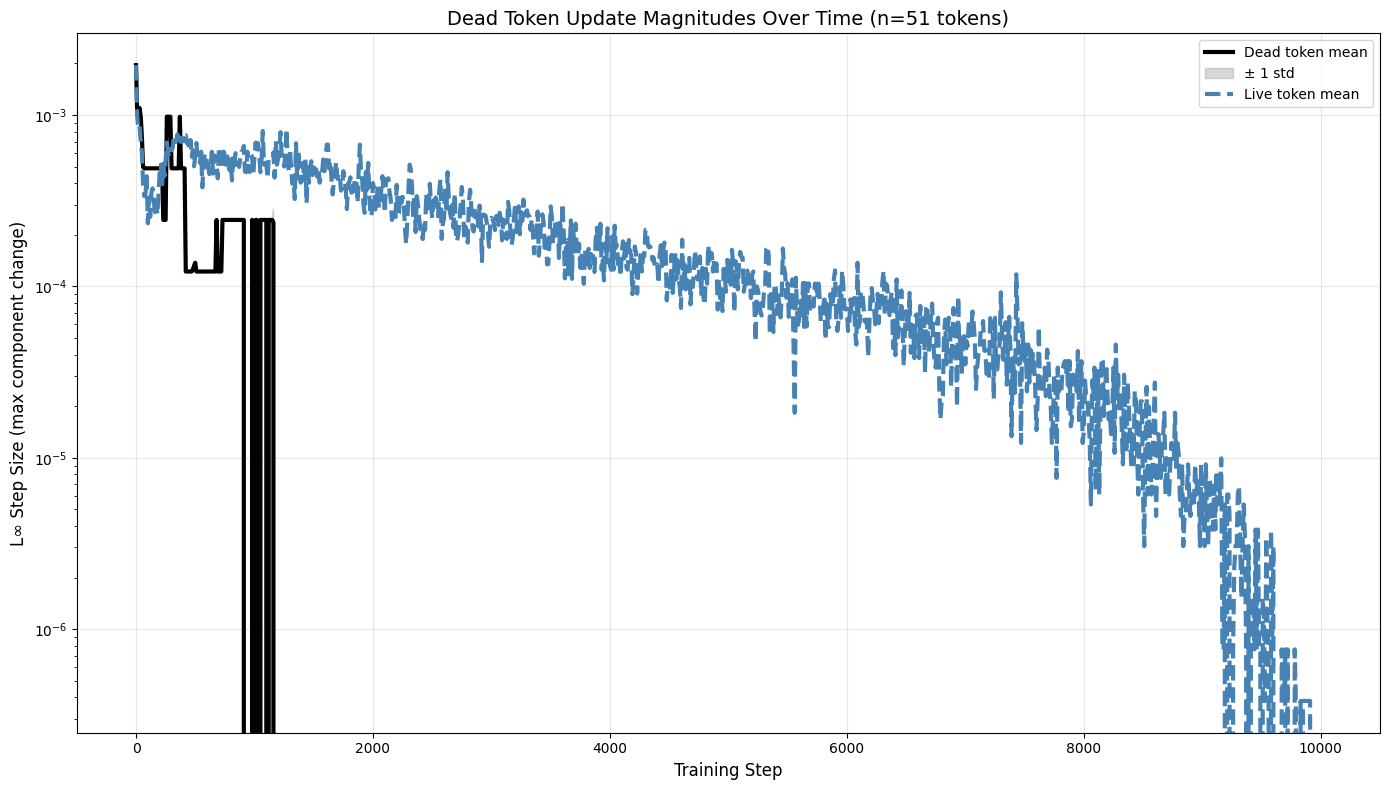


✓ All dead tokens plot complete


In [30]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Plot each dead token as a thin transparent line
for token_idx in range(len(dead_token_ids)):
    ax.plot(recorded_steps, dead_step_sizes[:, token_idx].numpy(), 
            linewidth=1, alpha=DEAD_TOKEN_ALPHA, color='crimson')

# Overlay mean ± std
mean_step_size = dead_step_sizes.mean(dim=1).numpy()
std_step_size = dead_step_sizes.std(dim=1).numpy()

ax.plot(recorded_steps, mean_step_size, linewidth=3, color='black', label='Dead token mean', zorder=10)
ax.fill_between(recorded_steps, mean_step_size - std_step_size, mean_step_size + std_step_size, 
                alpha=0.3, color='gray', label='± 1 std', zorder=5)

# Compare to live tokens (mean)
live_mean = live_step_sizes.mean(dim=1).numpy()
ax.plot(recorded_steps, live_mean, linewidth=3, color='steelblue', linestyle='--', label='Live token mean', zorder=10)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('L∞ Step Size (max component change)', fontsize=12)
ax.set_title(f'Dead Token Update Magnitudes Over Time (n={len(dead_token_ids)} tokens)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ All dead tokens plot complete")

## Plot 3: Gradient Magnitudes Over Time (Dead vs Live)

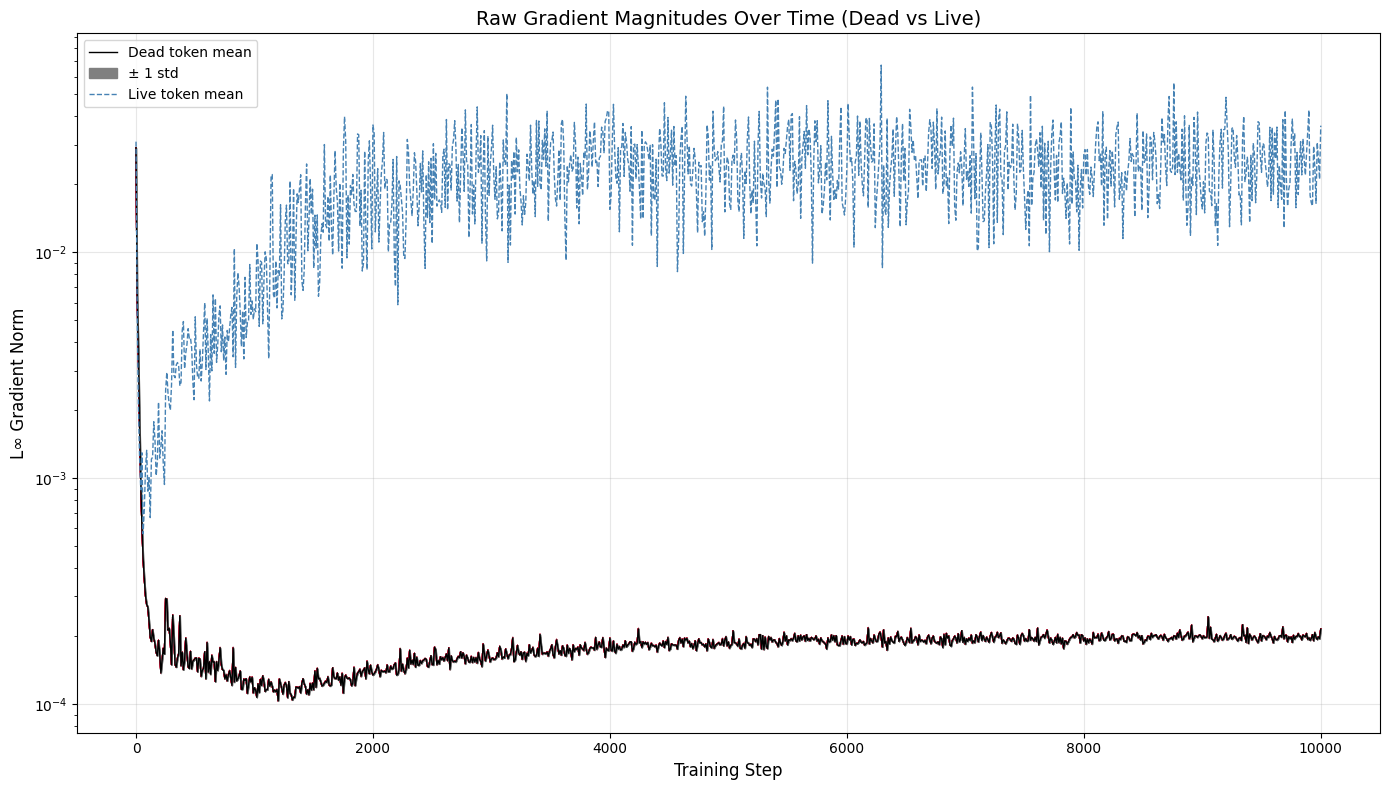


✓ Gradient magnitude plot complete


In [31]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Dead token gradients
for token_idx in range(len(dead_token_ids)):
    ax.plot(recorded_steps, dead_grad_norms[:, token_idx].numpy(), 
            linewidth=1, alpha=DEAD_TOKEN_ALPHA, color='crimson')

dead_grad_mean = dead_grad_norms.mean(dim=1).numpy()
dead_grad_std = dead_grad_norms.std(dim=1).numpy()

ax.plot(recorded_steps, dead_grad_mean, linewidth=1, color='black', label='Dead token mean', zorder=10)
ax.fill_between(recorded_steps, dead_grad_mean - dead_grad_std, dead_grad_mean + dead_grad_std, 
                alpha=1, color='gray', label='± 1 std', zorder=5)

# Live token gradients (mean)
live_grad_mean = live_grad_norms.mean(dim=1).numpy()
ax.plot(recorded_steps, live_grad_mean, linewidth=1, color='steelblue', linestyle='--', label='Live token mean', zorder=10)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('L∞ Gradient Norm', fontsize=12)
ax.set_title(f'Raw Gradient Magnitudes Over Time (Dead vs Live)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Gradient magnitude plot complete")

## Statistics: Decay Rate

In [32]:
print(f"\n{'='*80}")
print(f"DEAD TOKEN DYNAMICS SUMMARY")
print(f"{'='*80}\n")

print(f"Step sizes (L∞ update magnitude):")
print(f"  Step {recorded_steps[0]}: {mean_step_size[0]:.6e} ± {std_step_size[0]:.6e}")
print(f"  Step {recorded_steps[-1]}: {mean_step_size[-1]:.6e} ± {std_step_size[-1]:.6e}")
print(f"  Ratio (final / initial): {mean_step_size[-1] / mean_step_size[0]:.4f}")

print(f"\nGradient magnitudes (L∞ norm):")
print(f"  Step {recorded_steps[0]}: {dead_grad_mean[0]:.6e} ± {dead_grad_std[0]:.6e}")
print(f"  Step {recorded_steps[-1]}: {dead_grad_mean[-1]:.6e} ± {dead_grad_std[-1]:.6e}")
print(f"  Ratio (final / initial): {dead_grad_mean[-1] / dead_grad_mean[0]:.4f}")

print(f"\nDead vs Live (at step {recorded_steps[-1]}):")
print(f"  Dead step size: {mean_step_size[-1]:.6e}")
print(f"  Live step size: {live_mean[-1]:.6e}")
print(f"  Ratio (dead / live): {mean_step_size[-1] / live_mean[-1]:.4f}")

print(f"\n{'='*80}")


DEAD TOKEN DYNAMICS SUMMARY

Step sizes (L∞ update magnitude):
  Step 0: 1.953125e-03 ± 0.000000e+00
  Step 10000: 0.000000e+00 ± 0.000000e+00
  Ratio (final / initial): 0.0000

Gradient magnitudes (L∞ norm):
  Step 0: 2.905273e-02 ± 0.000000e+00
  Step 10000: 2.150629e-04 ± 4.814893e-07
  Ratio (final / initial): 0.0074

Dead vs Live (at step 10000):
  Dead step size: 0.000000e+00
  Live step size: 0.000000e+00
  Ratio (dead / live): nan



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_76508/2414115375.py:18: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  Ratio (dead / live): {mean_step_size[-1] / live_mean[-1]:.4f}")


## Interpretation

**What we're looking for:**

1. **Decay over time**: Do dead token step sizes decrease as training progresses?
2. **Convergence**: Do all dead tokens behave similarly (tight band)?
3. **Comparison to live**: Are dead token updates smaller than live token updates?

**Hypothesis:**
- Early: Large gradients (model predicts dead tokens uniformly)
- Late: Small gradients (model learns, rarely predicts dead tokens)
- Updates decay exponentially within ~100 steps